# Bring your own containers to Braket Jobs

Amazon Braket has pre-configured containers for executing Amazon Braket Hybrid Jobs, which are sufficient for many use cases involving the Braket SDK and PennyLane. However, if we want to use custom packages outside the scope of pre-configured containers, we will need to supply a custom-built container. In this tutorial, we show how to use Braket Job to train a quantum machine learning model using BYOC (Bring Your Own Container).

<div class="alert alert-block alert-info">
<b>Note:</b> Building the docker image in this notebook may require 4GB of memory. If you plan to use an Amazon Braket notebook instance to run this notebook, it is suggested to use a larger notebook instance, for example ml.t3.large.
</div>

## 1 Prepare algorithm script
This section introduces the algorithm script for a text sentiment classifier. The complete script for this notebook is [here](algorithm_script.py). We will not go through the script line by line. Instead, we highlight the part that is important for understanding the Braket Job.

### Problem setup
The quantum machine learning problem we are targeting is to classify the positive and negative sentiments of a sentence. We use four sentences in this example:

"I eat a banana every day." <br>
"Bananas are not for her." <br>
"Banana shakes are delicious." <br>
"How can you like bananas?" <br>

The first and the third sentence have positive sentiment on bananas, which are labeled as +1. The second and the fourth sentence have negative sentiment, which are labeled as -1. To input the sentence to a quantum machine learning model, we use spaCy package to embed the sentences into 1D vectors.

In [1]:
%%capture captured
!pip install ipywidgets
!pip install spacy_sentence_bert

In [2]:
import spacy_sentence_bert

nlp = spacy_sentence_bert.load_model("xx_distiluse_base_multilingual_cased_v2")
banana_string = ["I eat a banana every day.",
                "Bananas are not for her.",
                "Banana shakes are delicious.",
                "How can you like bananas?"
]
banana_embedding = [nlp(d) for d in banana_string]
data = [d.vector for d in banana_embedding]
label = [1, -1, 1, -1]

With the "xx_distiluse_base_multilingual_cased_v2" language model, each data point is now a vector with length 512. See the [spaCy page](https://spacy.io/universe/project/spacy-sentence-bert) for details. Note that the size of the embedding vectors depends on the language model. When choosing a different model, we would expect a different shape of embedding. 

In [3]:
for d in data:
    print("data size: {}".format(d.shape))    

data size: (512,)
data size: (512,)
data size: (512,)
data size: (512,)


### Quantum machine learning model

We choose [Circuit-centric quantum classifiers (CCQC)](https://arxiv.org/abs/1804.00633) as our quantum model. The figure below shows an example CCQC circuit with 7 qubits. The data (classical embedding from the language model) is input to the circuit as the initial state via [amplitude encoding](https://arxiv.org/abs/1803.07128). After the initial state are two entanglement layers. The first layer entangles each qubit with its nearest neighbor, and the second layer with each qubit's third nearest neighbor. A rotation gate is then applied to the first qubit. Finally, the measurement is only done on the first qubit. The classification criterion is only based on this measurement. If the measurement is positive, it predicts a positive sentiment (+1); otherwise, it predicts a negative one (-1).

<div align="center"><img src="ccqc_circuit.png"/></div>
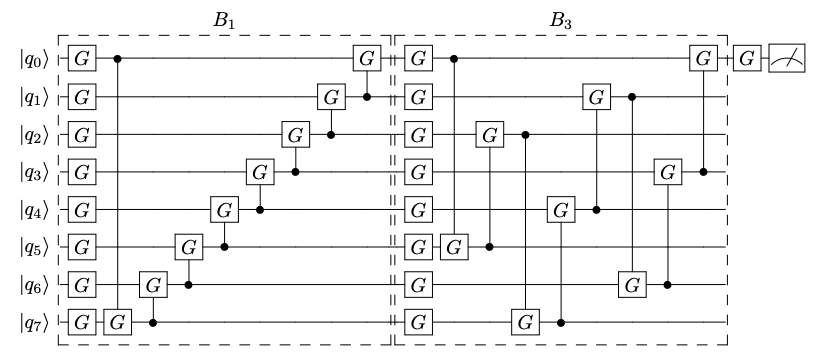

We use PennyLane as our machine learning framework. To use Braket on-demand simulators or QPUs, we set the device name to be "braket.aws.qubit". The device_arn will be passed to the algorithm script as the environment variable <code>os.environ["AMZN_BRAKET_DEVICE_ARN"]</code>; this variable is set when creating the job. For details about options of Braket devices in <code>qml.device</code>, see [Amazon Braket-Pennylane Plugin](https://github.com/aws/amazon-braket-pennylane-plugin-python). The quantum model is packaged in a CCQC class in the [algorithm script](algorithm_script.py).

### Monitor metrics and record results
We can monitor the progress of the hybrid job in the Amazon Braket console. <code>log_metric</code> records the metrics so that we can view the training progress in the "Monitor" console tab.  <code>save_job_result</code> allows us to view the result in the console and in the <code>job</code> variable. 

## 2 Prepare custom container
When we submit a quantum job, Amazon Braket starts a job instance based on EC2 and spins up a container to run our script. The environment is defined by the provided container instead of the local console where the job is submitted. If no container image is specified when submitting a job, the default container is the base Braket container. See the [developer guide](https://docs.aws.amazon.com/braket/index.html) for the configuration of the base container.

Amazon Braket Jobs provides three pre-configured containers for different use cases. See the [developer guide](https://docs.aws.amazon.com/braket/index.html) for the configuration of pre-configured containers. In this example, the spaCy package is not supported in any of the three containers. One option is to install the package through <code>pip</code> at the beginning of the algorithm script.  

In [4]:
# from pip._internal import main as pipmain
# pipmain(["install", "spacy"])

When the problem size is small, we can manage to use <code>pip</code> to configure the environment. However, for large-scale applications, we expect that this method would quickly become infeasible. Braket Job provides the "bring your own container (BYOC)" option to help you manage the environment of your hybrid job. BYOC not only allows us to define what Python packages are available, but to configure those settings that are hard to do by <code>pip</code> or Python alone. In the following, we go through the steps of building our own container.

### Preparation 1: Docker 
To build and upload our custom container, we must have [Docker](https://docs.docker.com/get-docker/) installed. Amazon Braket Notebook Instance has Docker pre-installed. This step can be skipped if you are using the terminal of a Braket Notebook Instance.

### Preparation 2: Dockerfile
A Dockerfile defines the environment and the software in the containers. We can start with the base Braket container and add packages according to our needs. For our quantum text classifier, we use the Dockerfile below. The first line in the dockerfile specifies the container template. We build our container upon the base Braket container. The rest of the file is to install the required packages (PennyLane and SpaCy etc.).

In [5]:
!cat dockerfile

FROM 292282985366.dkr.ecr.us-west-2.amazonaws.com/amazon-braket-base-jobs:1.0-cpu-py37-ubuntu18.04

RUN python3 -m pip install --upgrade pip

RUN python3 -m pip install amazon-braket-pennylane-plugin \
                           pennylane \
                           spacy \
                           spacy_sentence_bert


### Preparation 3: Initial script
An initial script is the script that will be executed when a container starts. For this example notebook, we build our container based on the base Braket container which already includes an initial script to run Braket Jobs. Therefore, we do not need to provide an initial script. The initial script configures the paths for container image and for user code. It sets up a container and downloads the algorithm script to run in the container. It also handles errors and logs error messages. See the developer guide for more information about the initial script associated with the base Braket container.

### Preparation 4: Create ECR
Amazon Elastic Container Registry (ECR) is a fully managed Docker container registry. Follow the [instructions](https://docs.aws.amazon.com/AmazonECR/latest/userguide/repository-create.html) to create a "private" repository using ECR console. For this example, we name our repository "amazon-braket-my-qtc" (my quantum text classifier).

Alternatively, following these [instructions](https://docs.aws.amazon.com/cli/latest/reference/ecr/create-repository.html), we can also create an ECR repository using the AWS CLI.

<b>Important</b>: The Amazon Braket managed policies only grant read access to repositories with the prefix `amazon-braket`. <b>In order to create (and later, push to) a repository, or to access repositories which are not prefixed with `amazon-braket`, you will need to attach additional permissions to your IAM identity.</b> If you are running this notebook on an Amazon Braket notebook instance, you may attach the [AmazonEC2ContainerRegistryFullAccess](https://docs.aws.amazon.com/AmazonECR/latest/userguide/security-iam-awsmanpol.html#security-iam-awsmanpol-AmazonEC2ContainerRegistryFullAccess) policy to the IAM role you specified when creating the notebook instance.

<b>Important: By default, Braket Jobs can only access repositories with names beginning in `amazon-braket`.</b> If you would like to access a repository with a different prefix, you will need to pass an IAM role with access to that repository using the `role_arn` argument of the `AmazonQuantumJob.create()` function.

In [6]:
# !aws ecr create-repository --repository-name amazon-braket-my-qtc

Now that we have finished the prerequisites, it's time to build our container!

### Action 1: Log into AWS CLI and Docker
If you haven't already, follow the [instructions](https://docs.aws.amazon.com/cli/latest/userguide/cli-configure-quickstart.html) to configure your AWS credentials using the AWS CLI. Then, run the following snippet in the terminal to log into Docker. Replace all &lt;XXX&gt; below with your own credentials. You will see "Login Succeeded" twice when it's done.

<code>aws ecr get-login-password --region us-west-2 | docker login --username AWS --password-stdin 292282985366.dkr.ecr.us-west-2.amazonaws.com
aws ecr get-login-password --region &lt;YOUR_AWS_REGION&gt; | docker login --username AWS --password-stdin &lt;YOUR_ACCOUNT_ID&gt;.dkr.ecr.&lt;YOUR_AWS_REGION&gt;.amazonaws.com</code>

Note that the commands log into Docker twice. The first command logs into the public registry containing the Braket base container that you will base your Docker image on. The second command logs into your private registry. 

If the terminal does not support interactive login, you can also run the following commands to log in.

<code>docker login -u AWS -p $(aws ecr get-login-password --region us-west-2) 292282985366.dkr.ecr.us-west-2.amazonaws.com
docker login -u AWS -p $(aws ecr get-login-password --region &lt;YOUR_AWS_REGION&gt;) &lt;YOUR_ACCOUNT_ID&gt;.dkr.ecr.&lt;YOUR_AWS_REGION&gt;.amazonaws.com</code>

### Action 2: Build and push the image
Go to the folder containing your Dockerfile. Run the lines below to build and push the image to your ECR. Remember to replace all &lt;XXX&gt; in the code with your own credentials. When it completes, you will see all layers are pushed in the terminal, and a new image will appear in our ECR console under the "amazon-braket-my-qtc" repository. If running into memory error when building an image due to the size of the language model, you can increase the memory limit in Docker.<br>
<code>docker build -t dockerfile .
docker tag dockerfile:latest &lt;YOUR_ACCOUNT_ID&gt;.dkr.ecr.&lt;YOUR_AWS_REGION&gt;.amazonaws.com/amazon-braket-my-qtc:latest
docker push &lt;YOUR_ACCOUNT_ID&gt;.dkr.ecr.&lt;YOUR_AWS_REGION&gt;.amazonaws.com/amazon-braket-my-qtc:latest
</code>
Once the container image is uploaded, it is ready to be used in a Braket Job!

### The build-and-push shell script
The above procedure walks you through the steps to create a container image. This procedure can be automated in a shell script. The [example script](build_and_push.sh) is provided in the same folder of this notebook. The script automatically formulates the commands to build and to push the container image to the ECR repository you assign. If the repository does not exist, it creates one. To use this shell script, the IAM identity that runs the script requires permissions to create the repository and push the image to the repository. If your IAM identity doesn't have these permissions, you can attach the [AmazonEC2ContainerRegistryFullAccess](https://docs.aws.amazon.com/AmazonECR/latest/userguide/security-iam-awsmanpol.html#security-iam-awsmanpol-AmazonEC2ContainerRegistryFullAccess) policy or select only the relevant permissions if you require granular control.

Assuming "amazon-braket-my-qtc" is your repository name, all you need to do is to prepare the Dockerfile and run the command<br>
<code>sh build_and_push.sh amazon-braket-my-qtc
</code>
in the terminal. Alternatively you can uncomment and run the following cell:

In [7]:
# !sh build_and_push.sh amazon-braket-my-qtc

## 3 Submit your job
Now that we have prepared an algorithm script and the container for the job, we can submit the hybrid job to AWS using <code>AwsQuantumJob.create</code>. Remember to provide the container we just created via the <code>image_uri</code> keyword.

<div class="alert alert-block alert-warning">
<b>Caution:</b> The job that is created below will take a long time to run (roughly 90 minutes) and will incur simulation costs up to $40 for running tasks on the SV1 on-demand simulator. Please uncomment and run the job only if you are comfortable with the time and cost.
</div>

In [8]:
# from braket.aws import AwsQuantumJob

# image_uri = "<aws_account_id>.dkr.ecr.<your_region>.amazonaws.com/amazon-braket-my-qtc:latest"

# job = AwsQuantumJob.create(
#     device="arn:aws:braket:::device/quantum-simulator/amazon/sv1",
#     source_module="algorithm_script.py",
#     entry_point="algorithm_script:main",
#     wait_until_complete=False,
#     job_name="my-aws-job",
#     image_uri=image_uri,
# )

In [9]:
print("Task Summary")
print(job.result()['task summary'])
print('Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).')
print(f"Estimated cost to run tasks in this job: {job.result()['estimated cost']} USD")

Task Summary
{'arn:aws:braket:::device/quantum-simulator/amazon/sv1': {'shots': 0, 'tasks': {'COMPLETED': 11800}, 'execution_duration': 1721.538, 'billed_execution_duration': 35400.0}}
Note: Charges shown are estimates based on your Amazon Braket simulator and quantum processing unit (QPU) task usage. Estimated charges shown may differ from your actual charges. Estimated charges do not factor in any discounts or credits, and you may experience additional charges based on your use of other services such as Amazon Elastic Compute Cloud (Amazon EC2).
Estimated cost to run tasks in this job: 44.25 USD


## 4 Evaluate results
Once training is completed, we can evaluate how our quantum model performs. First, we initialize the CCQC model. 

In [10]:
from algorithm_script import CCQC

device="arn:aws:braket:::device/quantum-simulator/amazon/sv1"
qml_model=CCQC(nwires = 9, device=device)

We then retrieve the trained weights from <code>job.result()</code>. 

In [11]:
# The cell completes when the job finishes. It may take 90 minutes.
weights = job.result()['weights']

If we lose the <code>job</code> variable, we can always retrieve it by its arn which can be found in the Braket console.

In [12]:
# job_arn = "your-job-arn"
# job = AwsQuantumJob(job_arn)

Using the trained weights, we can make the prediction for each sentence with the <code>predict</code> function of our model. See the [algorithm script](algorithm_script.py) for definitions.

In [13]:
for i in range(4):
    print(banana_string[i])
    pred = qml_model.predict(*weights, data=data[i])
    print("label: {}  predict:{}".format(label[i], pred))
    print()

I eat a banana every day.
label: 1  predict:1

Bananas are not for her.
label: -1  predict:-1

Banana shakes are delicious.
label: 1  predict:1

How can you like bananas?
label: -1  predict:-1



We can also test our quantum model on a sentence it has not seen.

In [14]:
test_string = "A banana a day keeps the doctor away."
test_data = nlp(test_string).vector
test_label = 1
print(test_string)
pred = qml_model.predict(*weights, data=test_data)
print("label: {}  predict:{}".format(test_label, pred))

A banana a day keeps the doctor away.
label: 1  predict:1


## Summary
In this notebook, we demonstrated a use case that requires Python packages not supported by any of the pre-configured containers provided by Braket Jobs. We have learned the steps to prepare a Dockerfile and build our own container that supports our use case. Using Braket Jobs with BYOC provides the flexibility of defining custom environments and the convenience of switching between environments for different applications.